In [298]:
!pip install folium

In [299]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_936868e3b7a041a29ed5e6d8d6527c8e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='c75VEKJovc437dcCqrvx-o1BIBaBzO-f8dFNskMKpSDJ',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_936868e3b7a041a29ed5e6d8d6527c8e.get_object(Bucket='datascience-donotdelete-pr-dbwhvmvxvlzh9z',Key='listings_summary.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_listing_summ = pd.read_csv(body)

In [300]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
import folium
%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use(['seaborn-darkgrid'])

In [301]:
df_listing_summ.shape

(22552, 96)

In [302]:
#ignore unwanted columns like URLs
columns_to_keep = ['id','host_has_profile_pic','host_since',
                   'latitude', 'longitude','property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'price', 'cleaning_fee',
                   'security_deposit', 'minimum_nights',  
                   'instant_bookable', 'cancellation_policy','availability_365']
df_listing_summ = df_listing_summ[columns_to_keep].set_index('id')

In [303]:
df_listing_summ.shape

(22552, 18)

In [304]:
#Check null values in each column for further cleaning
df_listing_summ.isnull().sum()

host_has_profile_pic      26
host_since                26
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bathrooms                 32
bedrooms                  18
bed_type                   0
amenities                  0
price                      0
cleaning_fee            7146
security_deposit        9361
minimum_nights             0
instant_bookable           0
cancellation_policy        0
availability_365           0
dtype: int64

In [305]:
#Convert f,t to 0 or 1
df_listing_summ['instant_bookable'] = df_listing_summ['instant_bookable'].map({'f':0,'t':1})

In [306]:
#fill f for N/A in host_has_profile_pic column for further correct mapping
set(df_listing_summ['host_has_profile_pic'])
df_listing_summ['host_has_profile_pic'].fillna('f',inplace=True)

In [307]:
#Convert f,t to 0 or 1
df_listing_summ['host_has_profile_pic'] = df_listing_summ['host_has_profile_pic'].map({'f':0,'t':1})

In [308]:
#Remove $ from price, fee columns and convert to float
df_listing_summ['price'] = df_listing_summ['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['cleaning_fee'] = df_listing_summ['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['security_deposit'] = df_listing_summ['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)

In [309]:
#cleaning_fee cleanup of N/a replace with median value
df_listing_summ['cleaning_fee'].fillna(df_listing_summ['cleaning_fee'].median(), inplace=True)

In [310]:
#security_deposit cleanup of N/a replace with median value
df_listing_summ['security_deposit'].fillna(df_listing_summ['security_deposit'].median(), inplace=True)

In [311]:
#Check distribution of price column
df_listing_summ['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

### As we see above 75% of prices are near 70 Euros , but min is 0 & max is 9000. Lets drop anything above 200

In [312]:
df_listing_summ.drop(df_listing_summ[ (df_listing_summ.price > 200) | (df_listing_summ.price == 0) ].index, axis=0, inplace=True)
df_listing_summ['price'].describe()

count    22132.000000
mean        54.567188
std         33.198252
min          1.000000
25%         30.000000
50%         45.000000
75%         69.000000
max        200.000000
Name: price, dtype: float64

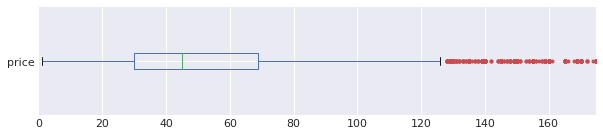

In [313]:
# boxplot of price column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_listing_summ['price'].plot(kind='box', xlim=(0, 175), vert=False, flierprops=red_square, figsize=(10,2));

In [314]:
#cleanup bathroom , bedroom columns
df_listing_summ['bathrooms'].fillna(1,inplace=True)
df_listing_summ['bedrooms'].fillna(1,inplace=True)

# Display no. of rooms by type

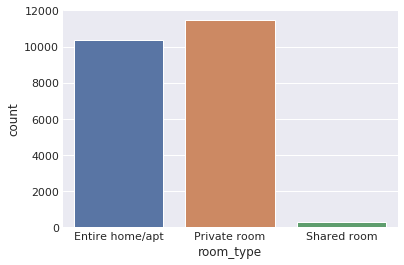

In [315]:
sns.countplot(x='room_type',data=df_listing_summ)

### This indicates most no. of listings rent entire home/apt. or private rooms

In [316]:
df_listing_summ['cancellation_policy'].value_counts()

flexible                       8985
moderate                       6993
strict_14_with_grace_period    6099
super_strict_30                  47
super_strict_60                   8
Name: cancellation_policy, dtype: int64

### This means most no. of listings have a flexible cancellation policy

### Create new columns for amenties

In [317]:
df_listing_summ['No_of_amentities'] = df_listing_summ['amenities'].apply(lambda x:len(x.split(',')))

In [318]:
df_listing_summ['Laptop_friendly_workspace'] = df_listing_summ['amenities'].str.contains('Laptop friendly workspace')
df_listing_summ['TV'] = df_listing_summ['amenities'].str.contains('TV')
df_listing_summ['Family_kid_friendly'] = df_listing_summ['amenities'].str.contains('Family/kid friendly')
df_listing_summ['Host_greets_you'] = df_listing_summ['amenities'].str.contains('Host greets you')
df_listing_summ['Smoking_allowed'] = df_listing_summ['amenities'].str.contains('Smoking allowed')
df_listing_summ['Hot_water'] = df_listing_summ['amenities'].str.contains('Hot water')
df_listing_summ['Fridge'] = df_listing_summ['amenities'].str.contains('Refrigerator')

In [319]:
#dropping amenities as we have inferred above as different categories
dropped = ['amenities']
df_listing_summ.drop(dropped,axis=1,inplace=True)

In [320]:
df_listing_summ.head()

,host_has_profile_pic,host_since,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,price,cleaning_fee,security_deposit,minimum_nights,instant_bookable,cancellation_policy,availability_365,No_of_amentities,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge
id,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1,2008-08-18,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,60.0,30.0,200.0,4,0,strict_14_with_grace_period,141,29,True,True,True,False,False,True,True
2695,1,2008-09-16,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,17.0,0.0,0.0,2,0,flexible,0,10,True,False,False,False,False,False,False
3176,1,2008-10-19,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,90.0,50.0,200.0,62,1,strict_14_with_grace_period,220,19,True,False,True,False,False,False,False
3309,1,2008-11-07,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,26.0,30.0,250.0,5,0,strict_14_with_grace_period,297,29,True,False,False,True,False,True,False
7071,1,2009-05-16,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,42.0,0.0,0.0,2,0,moderate,26,13,True,False,True,False,False,True,False


In [321]:
#Convert false,true to 0 or 1
df_listing_summ['Laptop_friendly_workspace'] = df_listing_summ['Laptop_friendly_workspace'].astype(int)
df_listing_summ['TV'] = df_listing_summ['TV'].astype(int)
df_listing_summ['Family_kid_friendly'] = df_listing_summ['Family_kid_friendly'].astype(int)
df_listing_summ['Host_greets_you'] = df_listing_summ['Host_greets_you'].astype(int)
df_listing_summ['Smoking_allowed'] = df_listing_summ['Smoking_allowed'].astype(int)
df_listing_summ['Hot_water'] = df_listing_summ['Hot_water'].astype(int)
df_listing_summ['Fridge'] = df_listing_summ['Fridge'].astype(int)

In [322]:
df_listing_summ.head()

,host_has_profile_pic,host_since,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,price,cleaning_fee,security_deposit,minimum_nights,instant_bookable,cancellation_policy,availability_365,No_of_amentities,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge
id,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1,2008-08-18,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,60.0,30.0,200.0,4,0,strict_14_with_grace_period,141,29,1,1,1,0,0,1,1
2695,1,2008-09-16,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,17.0,0.0,0.0,2,0,flexible,0,10,1,0,0,0,0,0,0
3176,1,2008-10-19,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,90.0,50.0,200.0,62,1,strict_14_with_grace_period,220,19,1,0,1,0,0,0,0
3309,1,2008-11-07,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,26.0,30.0,250.0,5,0,strict_14_with_grace_period,297,29,1,0,0,1,0,1,0
7071,1,2009-05-16,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,42.0,0.0,0.0,2,0,moderate,26,13,1,0,1,0,0,1,0


### calculate distances from central berlin to check later if it influences price

In [323]:
from math import sin, cos, sqrt, atan2, radians

In [324]:
#Calculate distance from central berlin
def haversine_distance_central(row):
    berlin_lat,berlin_long = radians(52.5200), radians(13.4050)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [325]:
#Calculate distance from airport
def haversine_distance_airport(row):
    berlin_lat,berlin_long = radians(52.3733), radians(13.5064)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [326]:
#Calculate distance from berlin railway station
def haversine_distance_rail(row):
    berlin_lat,berlin_long = radians(52.5073), radians(13.3324)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [327]:
df_listing_summ['distance_central'] = df_listing_summ.apply(haversine_distance_central,axis=1)
df_listing_summ['distance_airport'] = df_listing_summ.apply(haversine_distance_airport,axis=1)
df_listing_summ['distance_railways'] = df_listing_summ.apply(haversine_distance_rail,axis=1)
df_listing_summ['distance_avg'] = ( df_listing_summ['distance_central'] + df_listing_summ['distance_airport'] + df_listing_summ['distance_railways'] )/3.0

In [328]:
df_listing_summ['distance_avg'].describe()

count    22132.000000
mean         9.408715
std          1.786757
min          7.499669
25%          8.289105
50%          9.007905
75%          9.964415
max         24.636447
Name: distance_avg, dtype: float64

In [329]:
df_listing_summ.head()

,host_has_profile_pic,host_since,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,price,cleaning_fee,security_deposit,minimum_nights,instant_bookable,cancellation_policy,availability_365,No_of_amentities,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge,distance_central,distance_airport,distance_railways,distance_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1,2008-08-18,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,60.0,30.0,200.0,4,0,strict_14_with_grace_period,141,29,1,1,1,0,0,1,1,1.625414,19.266232,5.632427,8.841357
2695,1,2008-09-16,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,17.0,0.0,0.0,2,0,flexible,0,10,1,0,0,0,0,0,0,3.171617,20.675116,6.697246,10.181326
3176,1,2008-10-19,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,90.0,50.0,200.0,62,1,strict_14_with_grace_period,220,19,1,0,1,0,0,0,0,1.872657,18.966373,6.536374,9.125135
3309,1,2008-11-07,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,26.0,30.0,250.0,5,0,strict_14_with_grace_period,297,29,1,0,0,1,0,1,0,4.457682,17.574477,1.468150,7.833436
7071,1,2009-05-16,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,42.0,0.0,0.0,2,0,moderate,26,13,1,0,1,0,0,1,0,2.664743,19.880937,6.871866,9.805849


In [330]:
df_listing_summ.sort_values(by='price',ascending=False,axis=0,inplace=True) #sorting frame by price desc

In [331]:
df_list_summ_top10000 = df_listing_summ.head(10000)
df_list_summ_top1000 = df_listing_summ.head(1000)

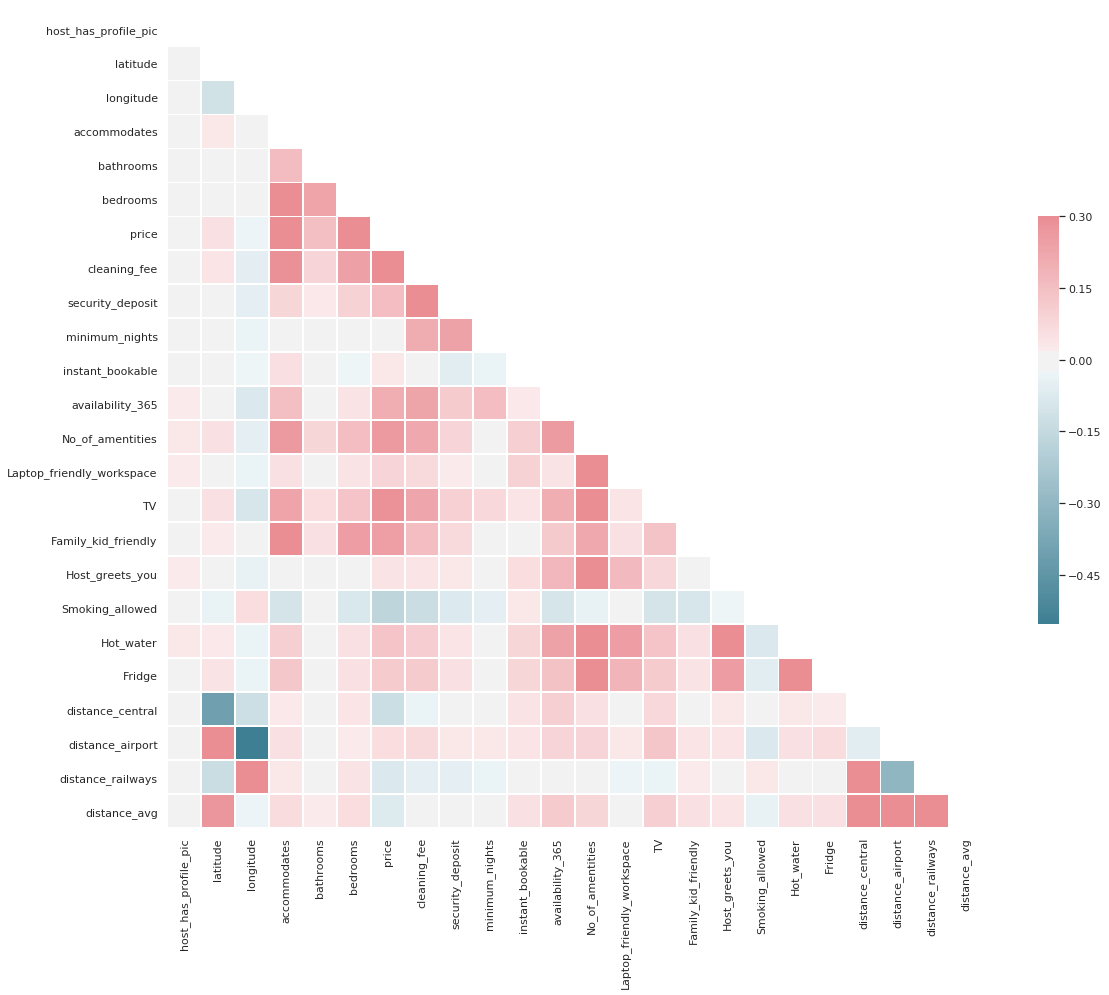

In [332]:
sns.set(style="white")
corr = df_listing_summ.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 15))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5},cbar=True);

## Price seems to depend largely on following factors
* No. of ameneties
* Is it family or kids friendly
* Cleaning fee
* Capacity i.e how many guests it can accomodate

Lets gets p-values & pearson's coefficients for price w.r.t. some columns

* p-value is < 0.001: we say there is strong evidence that the correlation is significant. 
* the p-value is < 0.05: there is moderate evidence that the correlation is significant. 
* the p-value is < 0.1: there is weak evidence that the correlation is significant. 
* the p-value is > 0.1: there is no evidence that the correlation is significant.

In [333]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(df_listing_summ['accommodates'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.5361129972955838  with a P-value of P = 0.0


In [334]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['cleaning_fee'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.38087552375274336  with a P-value of P = 0.0


In [335]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['security_deposit'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.1592453129486869  with a P-value of P = 1.2377472463014333e-125


In [336]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['distance_avg'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is -0.06999910431444747  with a P-value of P = 1.889668913174063e-25


In [337]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['Family_kid_friendly'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.24806336588064104  with a P-value of P = 1.3753763048581066e-307


In [338]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['No_of_amentities'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.26631903277747404  with a P-value of P = 0.0


In [339]:
lat = 52.509
long = 13.381
base = folium.Map(location=[lat,long], zoom_start=12) #base map setting
base

In [340]:
neighbourhoods = folium.map.FeatureGroup()

In [341]:
#central berlin location
inc_lat=52.520
inc_long=13.405
neighbourhoods.add_child(
folium.CircleMarker(
[inc_lat,inc_long],
radius = 14,
color='yellow',
fill=True,
fill_color='red',
fill_opacity=0.6
)
)
base.add_child(neighbourhoods)

In [342]:
#airport location
inc_lat=52.373
inc_long=13.506
neighbourhoods.add_child(
folium.CircleMarker(
[inc_lat,inc_long],
radius = 14,
color='yellow',
fill=True,
fill_color='green',
fill_opacity=0.6
)
)
base.add_child(neighbourhoods)

In [343]:
#railway station location
inc_lat=52.507
inc_long=13.332
neighbourhoods.add_child(
folium.CircleMarker(
[inc_lat,inc_long],
radius = 14,
color='yellow',
fill=True,
fill_color='black',
fill_opacity=0.6
)
)
base.add_child(neighbourhoods)

In [344]:
neighbourhoods = folium.map.FeatureGroup()
for inc_lat,inc_long in zip(df_list_summ_top1000.longitude,df_list_summ_top1000.latitude):
    neighbourhoods.add_child(
    folium.CircleMarker(
    [inc_long,inc_lat],
    radius = 5,
    color='yellow',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6
    )
)
base.add_child(neighbourhoods)

### This means top 1000 properties are around central berlin & railway station and very few near airport
### This is also evident from below dist plots where properties are mostly around central berlin & railway station

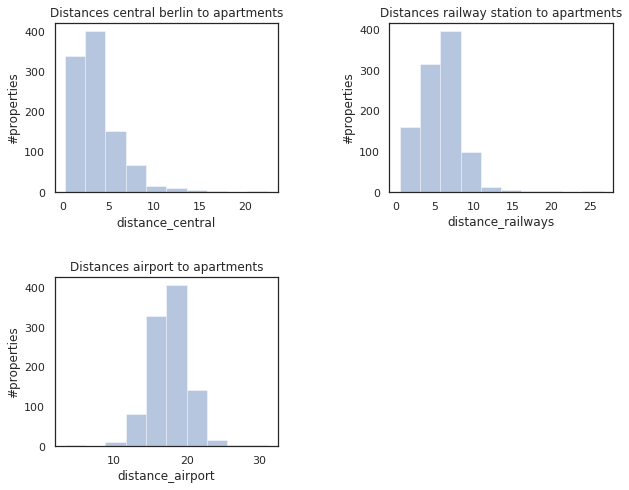

In [345]:
fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)

sns.distplot(df_list_summ_top1000["distance_central"], bins=10, kde=False,ax=ax0)
ax0.set_title('Distances central berlin to apartments')
ax0.set_xlabel('distance_central')
ax0.set_ylabel('#properties')

sns.distplot(df_list_summ_top1000["distance_railways"], bins=10, kde=False,ax=ax1)
ax1.set_title('Distances railway station to apartments')
ax1.set_xlabel('distance_railways')
ax1.set_ylabel('#properties')

sns.distplot(df_list_summ_top1000["distance_airport"], bins=10, kde=False,ax=ax2)
ax2.set_title('Distances airport to apartments')
ax2.set_xlabel('distance_airport')
ax2.set_ylabel('#properties')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.5)
plt.show()

In [372]:
body = client_936868e3b7a041a29ed5e6d8d6527c8e.get_object(Bucket='datascience-donotdelete-pr-dbwhvmvxvlzh9z',Key='reviews_summary.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_rsumm = pd.read_csv(body)

In [373]:
dropped = ['reviewer_name','comments']
df_rsumm.drop(dropped,axis=1,inplace=True)

In [374]:
df_rsumm['date'] = pd.to_datetime(df_rsumm['date'])
df_rsumm['year'] = df_rsumm['date'].dt.year
df_rsumm['month'] = df_rsumm['date'].dt.month
df_rsumm['day'] = df_rsumm['date'].dt.day

df_rsumm['year'] = df_rsumm['year'].astype(int)
df_rsumm['month'] = df_rsumm['month'].astype(int)
df_rsumm['day'] = df_rsumm['day'].astype(int)

In [375]:
df_rsumm.head()

,listing_id,id,date,reviewer_id,year,month,day
0,2015,69544350,2016-04-11,7178145,2016,4,11
1,2015,69990732,2016-04-15,41944715,2016,4,15
2,2015,71605267,2016-04-26,30048708,2016,4,26
3,2015,73819566,2016-05-10,63697857,2016,5,10
4,2015,74293504,2016-05-14,10414887,2016,5,14


In [376]:
df_rsumm.sort_values(['year', 'month'], ascending=[True, True],axis=0,inplace=True) #sorting frame by year,month asc

In [377]:
import datetime
def mapper(month):
    date = datetime.datetime(2000, month, 1)  # You need a dateobject with the proper month
    return date.strftime('%b')  # %b returns the months abbreviation, other options [here][1]

df_rsumm['month'] = df_rsumm['month'].apply(mapper)

In [378]:
df_rsumm['year'].value_counts()

2018    152448
2017    111799
2016     69303
2015     39470
2014     17702
2013      7422
2012      3092
2011       617
2010       107
2009         3
Name: year, dtype: int64

In [379]:
df_2015 = df_rsumm[df_rsumm['year'] == 2015]
df_2016 = df_rsumm[df_rsumm['year'] == 2016]
df_2017 = df_rsumm[df_rsumm['year'] == 2017]
df_2018 = df_rsumm[df_rsumm['year'] == 2018]

In [380]:
#df_2014['yearmonth'] = df_2014['month'].astype(str)+"-"+df_2014['year'].astype(str)
#df_2015['yearmonth'] = df_2015['month'].astype(str)+"-"+df_2015['year'].astype(str)
#df_2016['yearmonth'] = df_2016['month'].astype(str)+"-"+df_2016['year'].astype(str)
#df_2017['yearmonth'] = df_2017['month'].astype(str)+"-"+df_2017['year'].astype(str)
#df_2018['yearmonth'] = df_2018['month'].astype(str)+"-"+df_2018['year'].astype(str)

In [381]:
dropped = ['year','day','id','date','listing_id']
df_2015.drop(dropped,axis=1,inplace=True)
df_2016.drop(dropped,axis=1,inplace=True)
df_2017.drop(dropped,axis=1,inplace=True)
df_2018.drop(dropped,axis=1,inplace=True)

In [382]:
df_2015["count"] = df_2015.groupby("month")["reviewer_id"].transform('count')
df_2016["count"] = df_2016.groupby("month")["reviewer_id"].transform('count')
df_2017["count"] = df_2017.groupby("month")["reviewer_id"].transform('count')
df_2018["count"] = df_2018.groupby("month")["reviewer_id"].transform('count')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [383]:
dropped = ['reviewer_id']
df_2015.drop(dropped,axis=1,inplace=True)
df_2016.drop(dropped,axis=1,inplace=True)
df_2017.drop(dropped,axis=1,inplace=True)
df_2018.drop(dropped,axis=1,inplace=True)

In [384]:
df_2015 = df_2015.drop_duplicates()
df_2016 = df_2016.drop_duplicates()
df_2017 = df_2017.drop_duplicates()
df_2018 = df_2018.drop_duplicates()

In [385]:
df_2018.head()

,month,count
453,Jan,8780
92,Feb,8723
94,Mar,11008
96,Apr,13090
98,May,15654


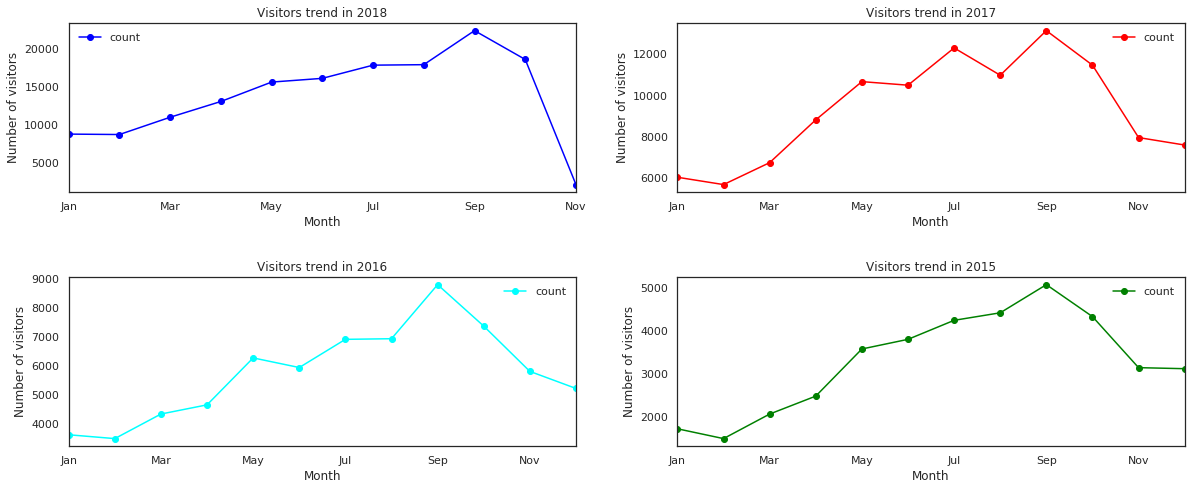

In [386]:
fig = plt.figure(figsize=(20, 6))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

df_2018.plot(kind='line', color='blue', x='month',y='count',marker='o',ax=ax0) # add to subplot 1
ax0.set_title('Visitors trend in 2018')
ax0.set_xlabel('Month')
ax0.set_ylabel('Number of visitors')

df_2017.plot(kind='line', color='red', x='month',y='count',marker='o',ax=ax1) # add to subplot 2
ax1.set_title('Visitors trend in 2017')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of visitors')

df_2016.plot(kind='line', color='cyan', x='month',y='count',marker='o',ax=ax2) # add to subplot 3
ax2.set_title('Visitors trend in 2016')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of visitors')

df_2015.plot(kind='line', color='green', x='month',y='count',marker='o',ax=ax3) # add to subplot 4
ax3.set_title('Visitors trend in 2015')
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of visitors')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5)
plt.show()

### Above plots indicate visitors peak during Sep each year